매장의 세일데이터를 이용하여 세일을 예측하는 인공신경말 모델을 쥬피터 노트북 파일로 만들고 옵티마이저 종류별 정확도와 로스율을 엑셀 쉬트에 기록해서 제출하시오
(은닉층은 2개로 하고 2개의 은닉층의 개수는 10개 이하로 노드를 생성하여 최적의 모델을 생성한다.
은닉층 2에서 나오는 활성화 함수는 'relu'를 사용하고 옵티마이저는 SGD, Momentum,AdaGrad, RMSProp, Adam 으로 사용한다.)

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score

In [143]:
bigmt = pd.read_csv('bigmart_train.csv')

bigmt.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [69]:
bigmt.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## 결측치 처리하기

### 매장 크기 결측치 처리하기

In [70]:
print(bigmt.groupby("Outlet_Type")["Outlet_Size"].value_counts())

Outlet_Type        Outlet_Size
Grocery Store      Small           528
Supermarket Type1  Small          1860
                   High            932
                   Medium          930
Supermarket Type2  Medium          928
Supermarket Type3  Medium          935
Name: count, dtype: int64


In [71]:
print(bigmt.groupby("Outlet_Location_Type")["Outlet_Size"].value_counts())

Outlet_Location_Type  Outlet_Size
Tier 1                Small          1458
                      Medium          930
Tier 2                Small           930
Tier 3                Medium         1863
                      High            932
Name: count, dtype: int64


In [144]:
# 매장 유형과 위치 유형별로  Outlet_Size의 최빈값 계산
size_mode = bigmt.groupby(['Outlet_Type', 'Outlet_Location_Type'])['Outlet_Size'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')

# 매장 유형 + 위치 유형 조합별 최빈값으로 채우기
def fill_outlet_size(row):
    if pd.isnull(row['Outlet_Size']):
        return size_mode.get((row['Outlet_Type'], row['Outlet_Location_Type']), 'Unknown')
    return row['Outlet_Size']

bigmt['Outlet_Size'] = bigmt.apply(fill_outlet_size, axis = 1)

#그래도 채우지 못한 값은 최종적으로 'Unknown' 으로 대체
bigmt['Outlet_Size'] = bigmt['Outlet_Size'].fillna('Unknown')

# 확인
print(bigmt['Outlet_Size'].isnull().sum())

#매장 사이즈 크기별 개수
print(f'매장 사이즈\n{bigmt["Outlet_Size"].value_counts()}')

0
매장 사이즈
Outlet_Size
Small      4243
Medium     2793
High        932
Unknown     555
Name: count, dtype: int64


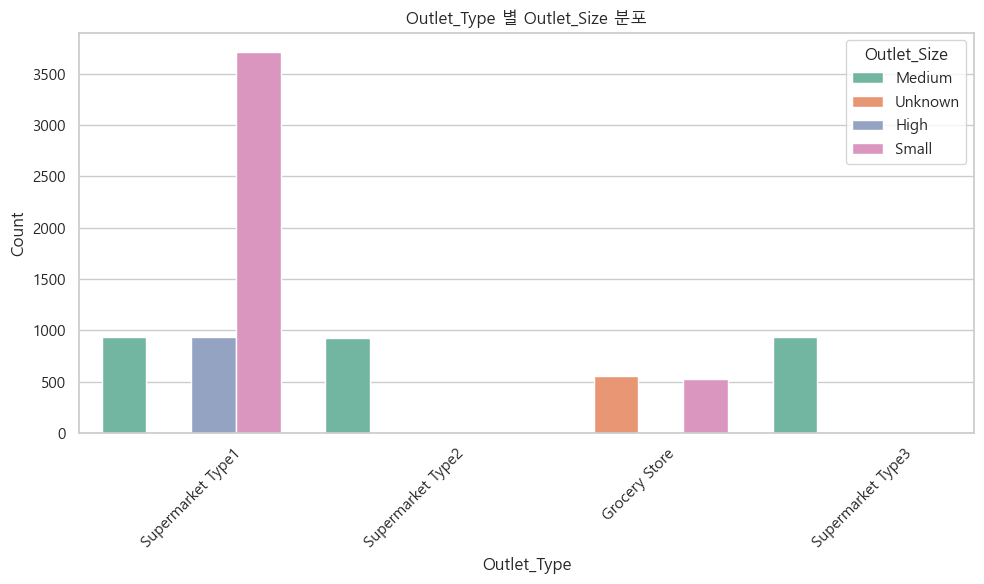

In [104]:
plt.figure(figsize=(10, 6))
sns.countplot(data=bigmt, x='Outlet_Type', hue='Outlet_Size', palette='Set2')
plt.title('Outlet_Type 별 Outlet_Size 분포')
plt.xlabel('Outlet_Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


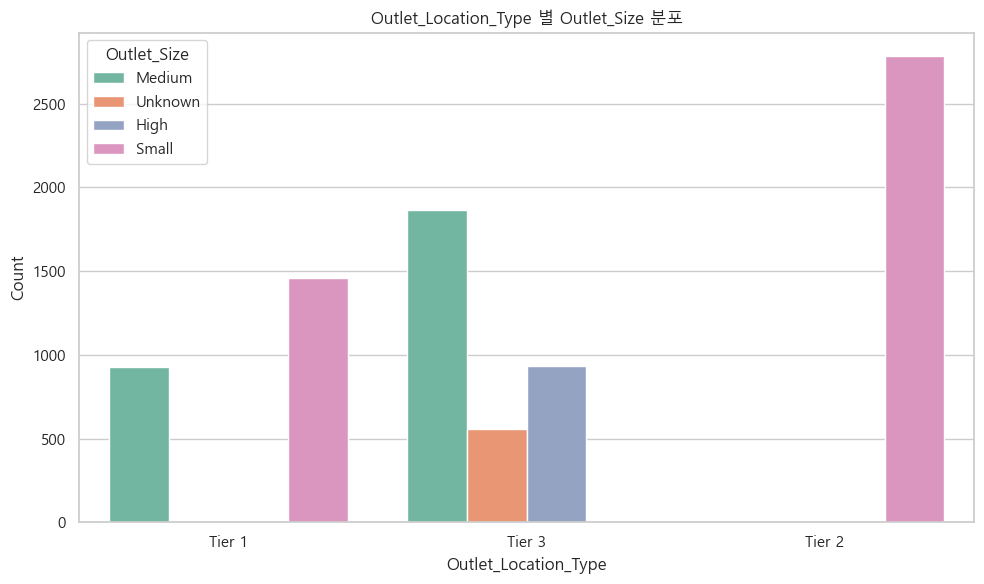

In [105]:
plt.figure(figsize=(10, 6))
sns.countplot(data=bigmt, x='Outlet_Location_Type', hue='Outlet_Size', palette='Set2')
plt.title('Outlet_Location_Type 별 Outlet_Size 분포')
plt.xlabel('Outlet_Location_Type')
plt.ylabel('Count')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\82109\AppData\Local\Temp\ipykernel_15300\2818563337.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=bigmt, x='Outlet_Size', order=bigmt['Outlet_Size'].value_counts().index, palette='pastel')


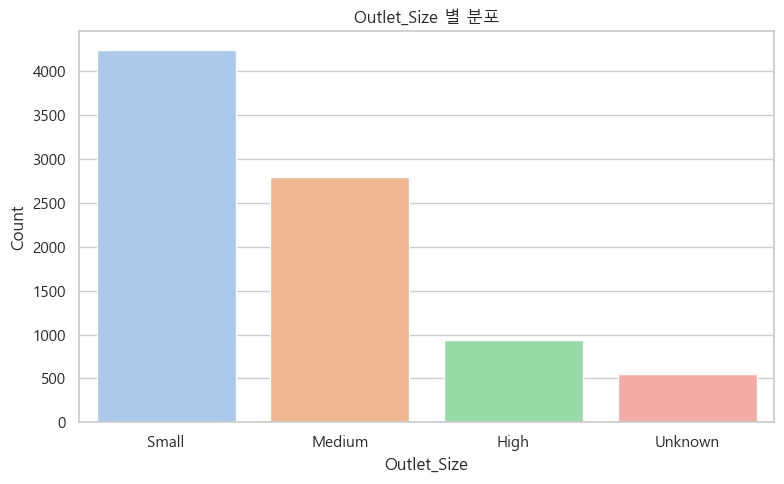

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=bigmt, x='Outlet_Size', order=bigmt['Outlet_Size'].value_counts().index, palette='pastel')
plt.title('Outlet_Size 별 분포')
plt.xlabel('Outlet_Size')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [140]:
# 'Unknown'인 행만 필터링
unknown_outlets = bigmt[bigmt["Outlet_Size"] == "Unknown"]

# 매장 위치 유형별 Unknown 개수
location_type_counts = unknown_outlets["Outlet_Location_Type"].value_counts()
print("매장 위치 유형별 Unknown 개수:")
print(location_type_counts)

# 매장 유형별 Unknown 개수
outlet_type_counts = unknown_outlets["Outlet_Type"].value_counts()
print("\n매장 유형별 Unknown 개수:")
print(outlet_type_counts)

매장 위치 유형별 Unknown 개수:
Outlet_Location_Type
Tier 3    555
Name: count, dtype: int64

매장 유형별 Unknown 개수:
Outlet_Type
Grocery Store    555
Name: count, dtype: int64


C:\Users\82109\AppData\Local\Temp\ipykernel_15300\3708253875.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=unknown_outlets, x='Outlet_Location_Type', ax=axes[0], palette='Set2')
C:\Users\82109\AppData\Local\Temp\ipykernel_15300\3708253875.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=unknown_outlets, x='Outlet_Type', ax=axes[1], palette='Set3')


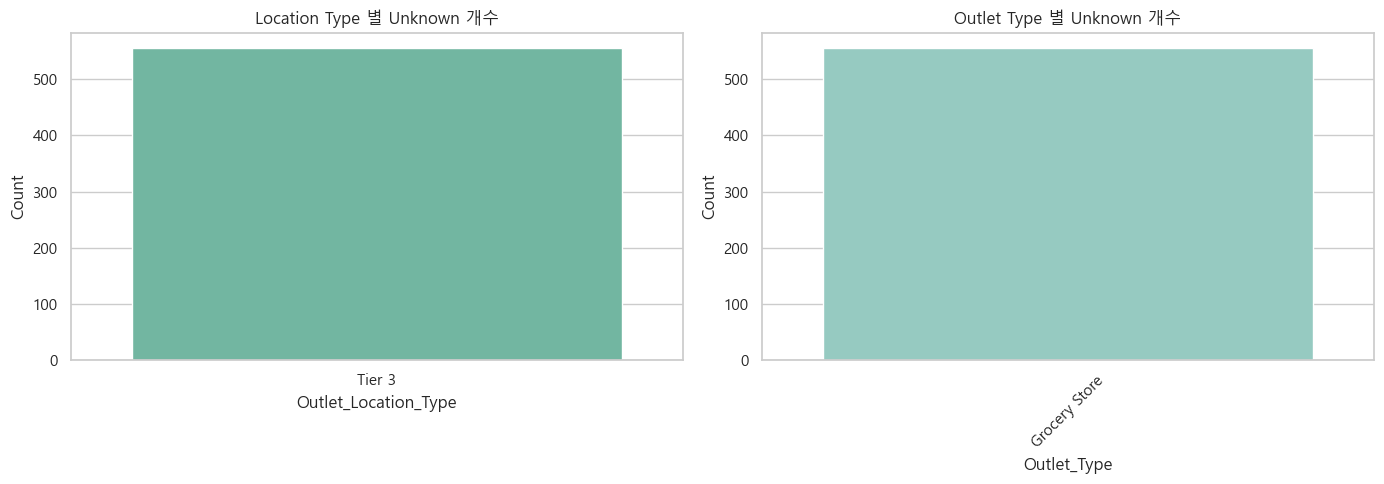

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

# 'Unknown'인 행만 필터링
unknown_outlets = bigmt[bigmt["Outlet_Size"] == "Unknown"]

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 그래프 1: Outlet_Location_Type 별 Unknown 개수
sns.countplot(data=unknown_outlets, x='Outlet_Location_Type', ax=axes[0], palette='Set2')
axes[0].set_title('Location Type 별 Unknown 개수')
axes[0].set_xlabel('Outlet_Location_Type')
axes[0].set_ylabel('Count')

# 그래프 2: Outlet_Type 별 Unknown 개수
sns.countplot(data=unknown_outlets, x='Outlet_Type', ax=axes[1], palette='Set3')
axes[1].set_title('Outlet Type 별 Unknown 개수')
axes[1].set_xlabel('Outlet_Type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [145]:
# Grocery Store 이면서 Outlet_Size가 Unknown 인 경우 Small로 채우기
bigmt.loc[(bigmt['Outlet_Type'] == 'Grocery Store') & (bigmt['Outlet_Size'] == 'Unknown'), 'Outlet_Size'] = 'Small'

### 상품무게 결측치 처리

### 품목 코드와 상품최대 소비 가격의 평균 값으로 결측치 처리하기

Step 1 - 채워진 개수: 1451
Step 2 - 채워진 개수: 12
Step 3 - 채워진 개수: 0
최종 남은 결측치: 0

채운 무게 평균: 12.87318
채운 무게 중앙값: 12.64092
최종 결측치 상태: 0


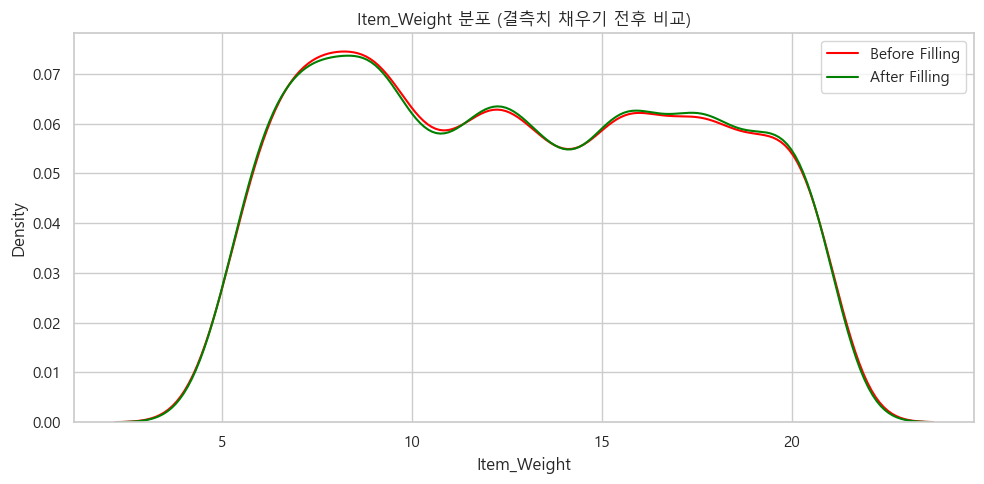

In [146]:
# 기존 무게 데이터를 복사하여 비교용으로 저장
old_weights = bigmt['Item_Weight'].copy()

# MRP를 구간화
bigmt['MRP_bin'] = pd.qcut(bigmt['Item_MRP'], q=4, labels=False)

# Step 1: Item_Type + Item_Identifier + MRP_bin으로 채움
step1 = bigmt['Item_Weight'].isnull().sum()
bigmt['Item_Weight'] = bigmt.groupby(
    ['Item_Type', 'Item_Identifier', 'MRP_bin']
)['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
step1_filled = step1 - bigmt['Item_Weight'].isnull().sum()

# Step 2: Item_Type + MRP_bin 으로 채움
step2 = bigmt['Item_Weight'].isnull().sum()
bigmt['Item_Weight'] = bigmt.groupby(
    ['Item_Type', 'MRP_bin']
)['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
step2_filled = step2 - bigmt['Item_Weight'].isnull().sum()

# Step 3: Item_Type 으로 최종 채움
step3 = bigmt['Item_Weight'].isnull().sum()
bigmt['Item_Weight'] = bigmt.groupby(
    'Item_Type'
)['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
step3_filled = step3 - bigmt['Item_Weight'].isnull().sum()

# 최종 결측치 확인
final_missing = bigmt['Item_Weight'].isnull().sum()

# 평균과 중앙값 확인
mean_weight = bigmt['Item_Weight'].mean()
median_weight = bigmt['Item_Weight'].median()

# 결과 출력
print(f"Step 1 - 채워진 개수: {step1_filled}")
print(f"Step 2 - 채워진 개수: {step2_filled}")
print(f"Step 3 - 채워진 개수: {step3_filled}")
print(f"최종 남은 결측치: {final_missing}\n")

print(f"채운 무게 평균: {mean_weight:.5f}")
print(f"채운 무게 중앙값: {median_weight:.5f}")

print("최종 결측치 상태:", bigmt['Item_Weight'].isnull().sum())

# 시각화를 위한 분포 비교
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(old_weights.dropna(), label='Before Filling', color='red')
sns.kdeplot(bigmt['Item_Weight'], label='After Filling', color='green')
plt.title('Item_Weight 분포 (결측치 채우기 전후 비교)')
plt.xlabel('Item_Weight')
plt.legend()
plt.tight_layout()
plt.show()

# MRP_bin 제거
bigmt.drop(columns=['MRP_bin'], inplace=True)

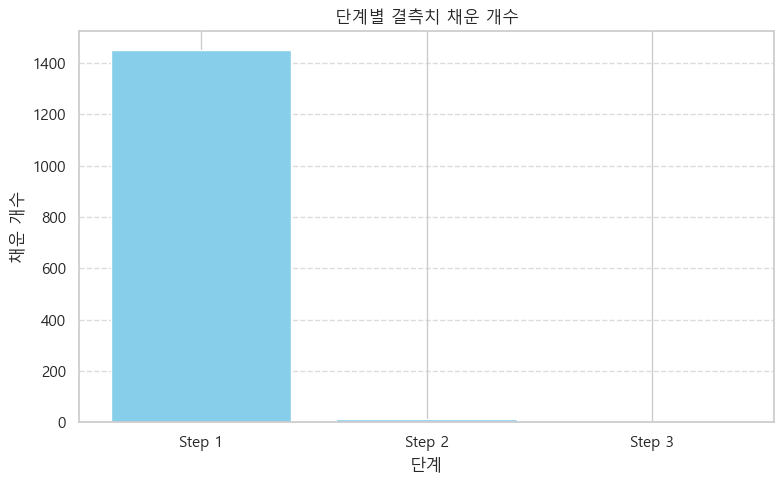

In [111]:
import matplotlib.pyplot as plt

steps = ['Step 1', 'Step 2', 'Step 3']
filled = [step1_filled, step2_filled, step3_filled]

plt.figure(figsize=(8, 5))
plt.bar(steps, filled, color='skyblue')
plt.title('단계별 결측치 채운 개수')
plt.xlabel('단계')
plt.ylabel('채운 개수')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


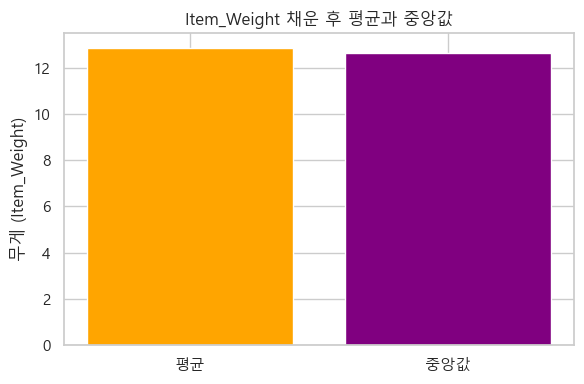

In [112]:
plt.figure(figsize=(6, 4))
plt.bar(['평균', '중앙값'], [mean_weight, median_weight], color=['orange', 'purple'])
plt.title('Item_Weight 채운 후 평균과 중앙값')
plt.ylabel('무게 (Item_Weight)')
plt.tight_layout()
plt.show()


In [12]:
bigmt.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## 상관관계 분석

### 피어슨 상관계수

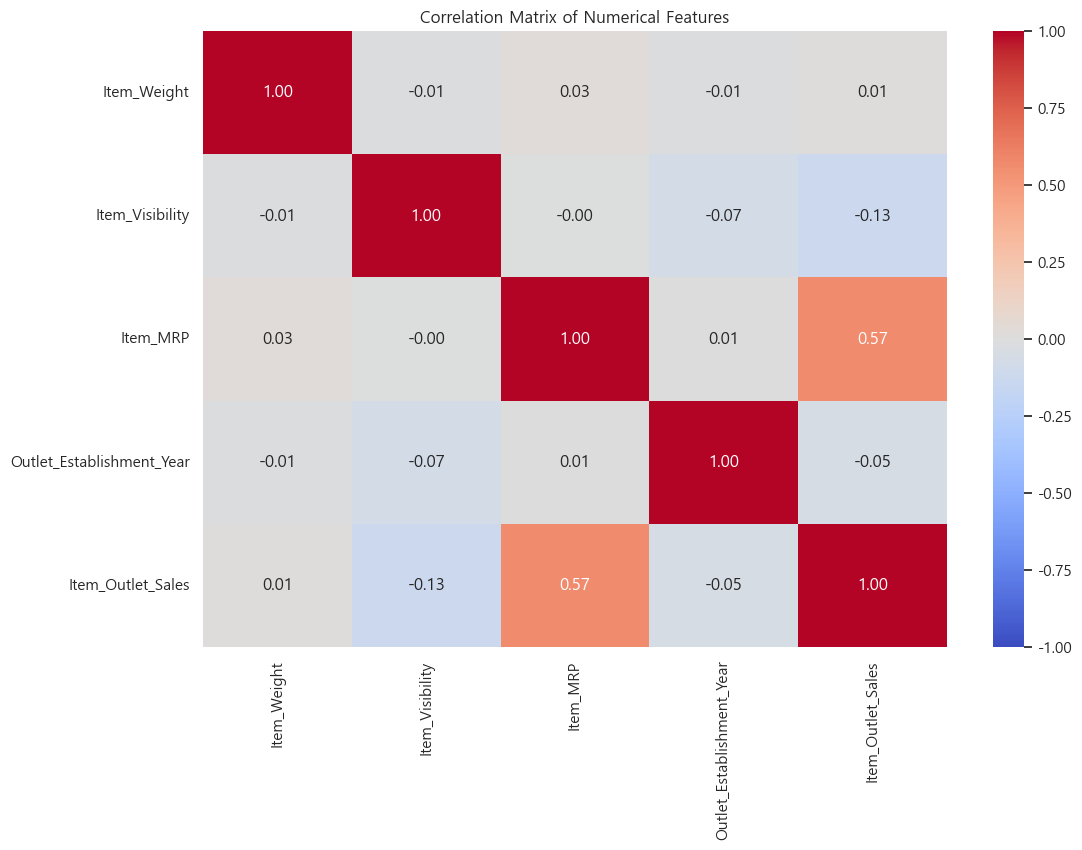

Correlation matrix of numerical features:
                           Item_Weight  Item_Visibility  Item_MRP  \
Item_Weight                   1.000000        -0.009434  0.026089   
Item_Visibility              -0.009434         1.000000 -0.001315   
Item_MRP                      0.026089        -0.001315  1.000000   
Outlet_Establishment_Year    -0.012688        -0.074834  0.005020   
Item_Outlet_Sales             0.013482        -0.128625  0.567574   

                           Outlet_Establishment_Year  Item_Outlet_Sales  
Item_Weight                                -0.012688           0.013482  
Item_Visibility                            -0.074834          -0.128625  
Item_MRP                                    0.005020           0.567574  
Outlet_Establishment_Year                   1.000000          -0.049135  
Item_Outlet_Sales                          -0.049135           1.000000  


In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 한글 폰트 설정
rcParams['font.family'] = 'Malgun Gothic'  # 이 부분을 다른 폰트로 변경할 수 있습니다
rcParams['axes.unicode_minus'] = False     # 유니코드 마이너스 문제 해결

# 수치형 변수만 추출
numerical_features = bigmt.select_dtypes(include=['float64', 'int64']).columns

# 상관행렬 계산
correlation_matrix = bigmt[numerical_features].corr()

# 히트맵으로 상관관계 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# 상관행렬 값 출력
print("Correlation matrix of numerical features:")
print(correlation_matrix)


In [147]:
bigmt.drop(columns=['Item_Weight'], inplace=True)

### ANOVA

In [15]:
from scipy.stats import f_oneway

# 범주형 변수 리스트
categorical_cols = ["Item_Identifier", "Item_Fat_Content", "Item_Type", 
                    "Outlet_Identifier", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]

# 각 범주형 변수에 대해 ANOVA 검정 수행
for column in categorical_cols:
    # 각 범주별 매출액 추출
    groups = [bigmt[bigmt[column] == category]['Item_Outlet_Sales'] for category in bigmt[column].unique()]
    
    # ANOVA를 통해 각 범주별 매출액 차이 검정
    f_statistic, p_value = f_oneway(*groups)
    
    print(f"ANOVA 결과 - {column}:")
    print(f"  F-statistic: {f_statistic:.4f}")
    print(f"  p-value: {p_value:.4f}")
    
    # p-value에 따라 결과 해석
    if p_value < 0.05:
        print("  -> 범주형 변수 '{column}'이 매출액에 유의미한 영향을 미칩니다.")
    else:
        print("  -> 범주형 변수 '{column}'이 매출액에 유의미한 영향을 미치지 않습니다.")
    print()


ANOVA 결과 - Item_Identifier:
  F-statistic: 3.3314
  p-value: 0.0000
  -> 범주형 변수 '{column}'이 매출액에 유의미한 영향을 미칩니다.

ANOVA 결과 - Item_Fat_Content:
  F-statistic: 1.7257
  p-value: 0.1412
  -> 범주형 변수 '{column}'이 매출액에 유의미한 영향을 미치지 않습니다.

ANOVA 결과 - Item_Type:
  F-statistic: 2.7007
  p-value: 0.0004
  -> 범주형 변수 '{column}'이 매출액에 유의미한 영향을 미칩니다.

ANOVA 결과 - Outlet_Identifier:
  F-statistic: 300.0791
  p-value: 0.0000
  -> 범주형 변수 '{column}'이 매출액에 유의미한 영향을 미칩니다.

ANOVA 결과 - Outlet_Size:
  F-statistic: 213.6910
  p-value: 0.0000
  -> 범주형 변수 '{column}'이 매출액에 유의미한 영향을 미칩니다.

ANOVA 결과 - Outlet_Location_Type:
  F-statistic: 53.9477
  p-value: 0.0000
  -> 범주형 변수 '{column}'이 매출액에 유의미한 영향을 미칩니다.

ANOVA 결과 - Outlet_Type:
  F-statistic: 894.6500
  p-value: 0.0000
  -> 범주형 변수 '{column}'이 매출액에 유의미한 영향을 미칩니다.



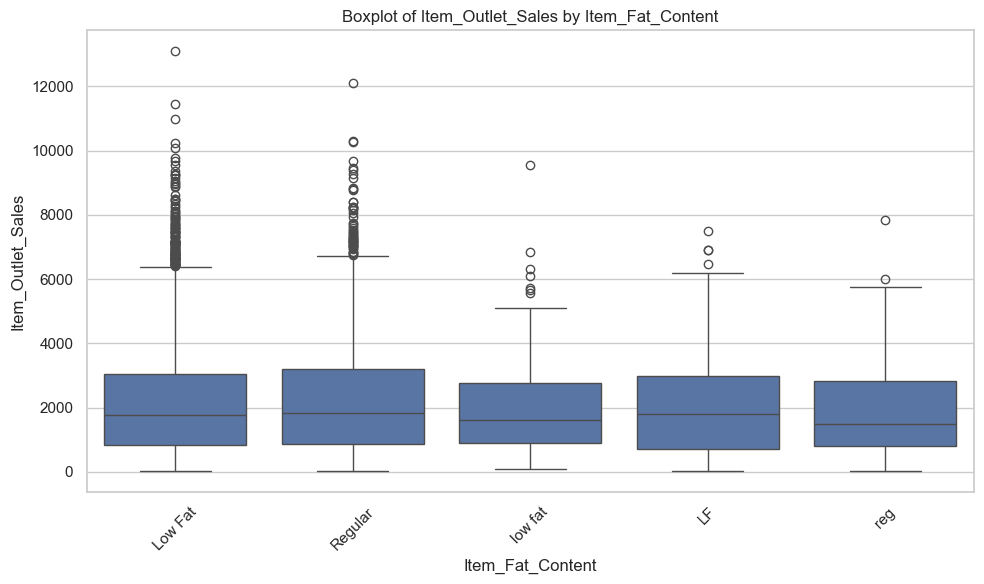

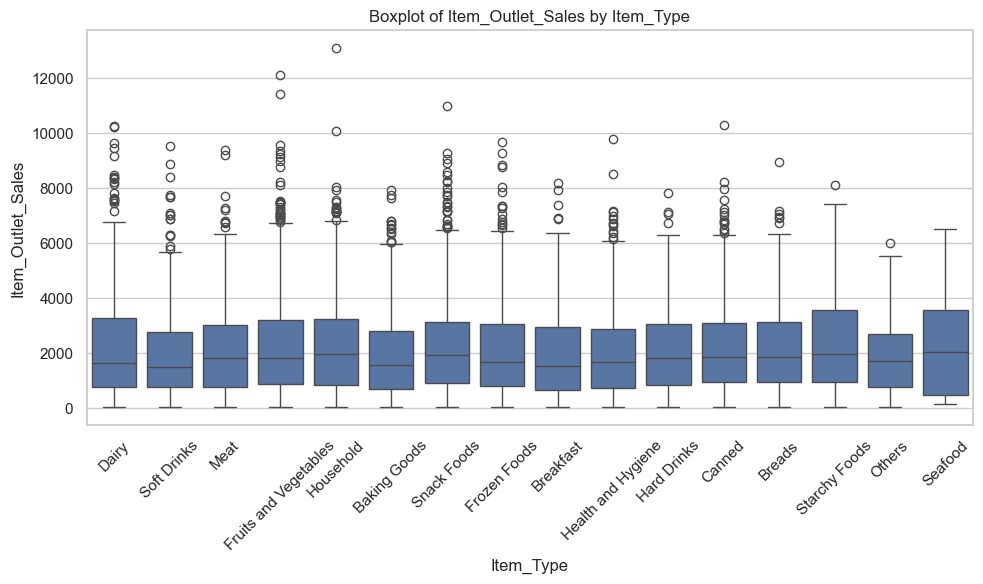

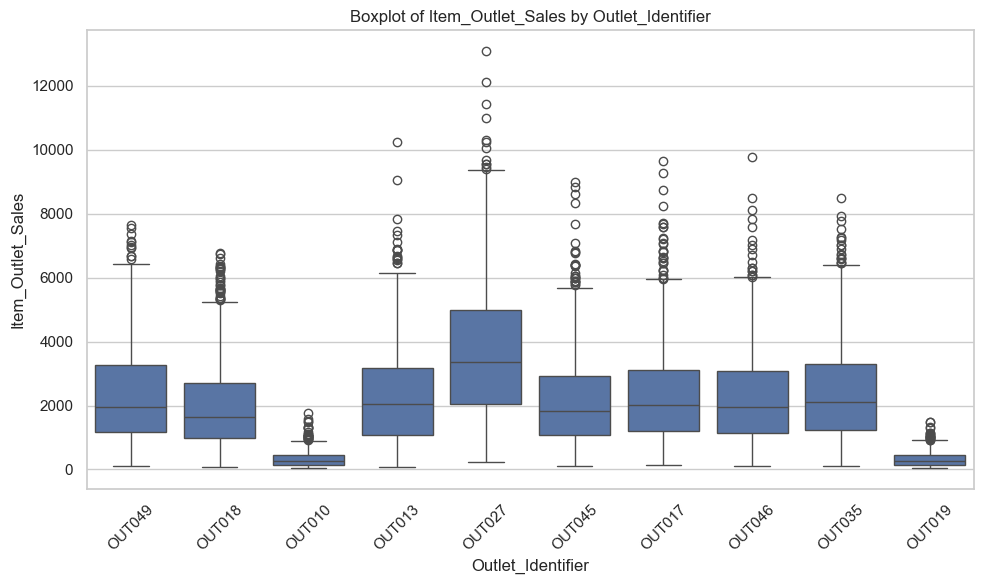

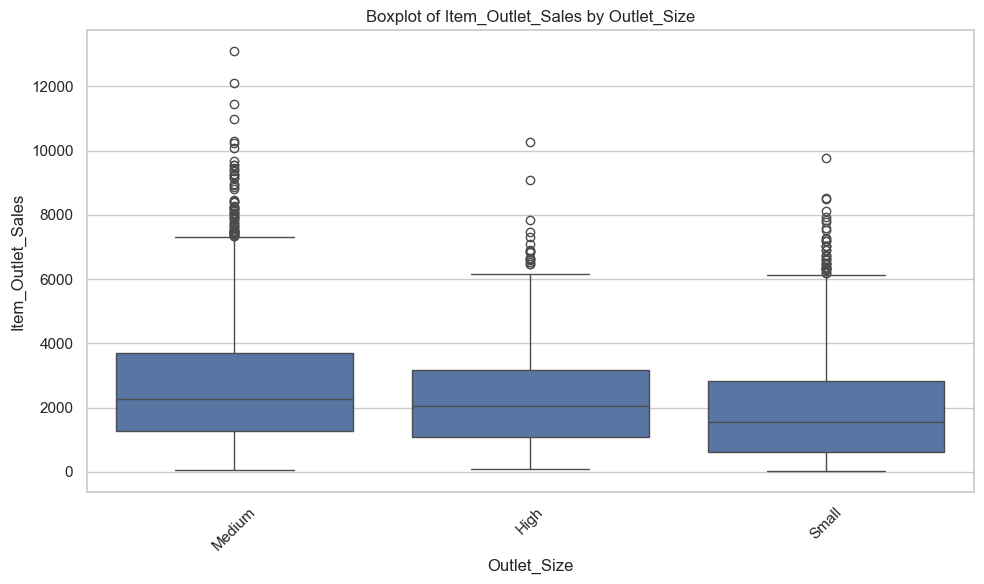

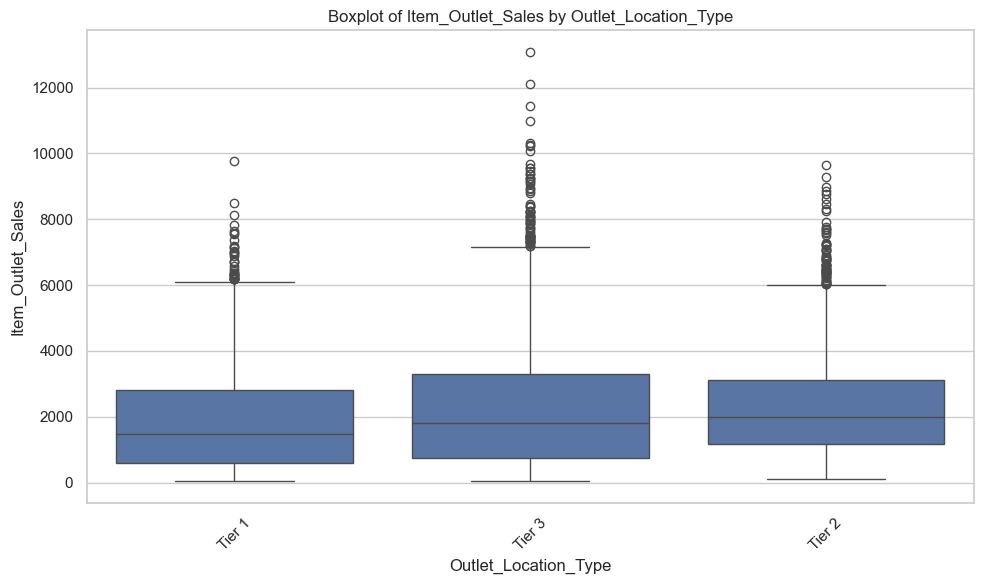

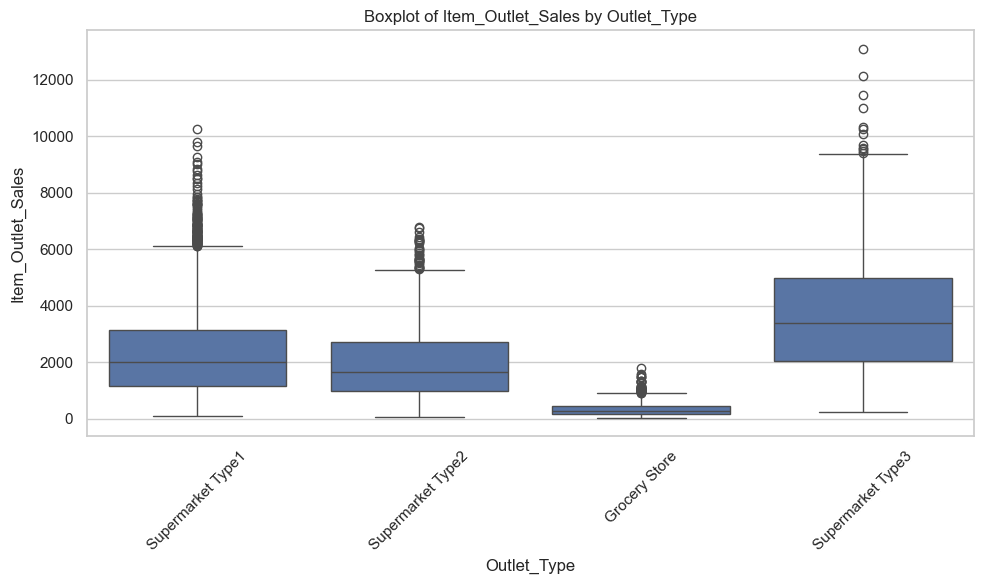

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정
sns.set(style="whitegrid")

# 범주형 변수 리스트
categorical_cols = [ "Item_Fat_Content", "Item_Type", 
                    "Outlet_Identifier", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]

# 그래프 출력
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='Item_Outlet_Sales', data=bigmt)
    plt.title(f'Boxplot of Item_Outlet_Sales by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 카이제곱 검정

In [41]:
from scipy.stats import chi2_contingency
import pandas as pd

# 범주형 변수 리스트
categorical_cols = ["Item_Identifier", "Item_Fat_Content", "Item_Type", 
                    "Outlet_Identifier", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]

# 매출액을 범주형으로 변환 (예: 매출액을 4개의 구간으로 나누기)
bigmt['Sales_Binned'] = pd.qcut(bigmt['Item_Outlet_Sales'], q=4, labels=False)

# 카이제곱 검정을 위한 결과 저장
chi2_results = {}

# 각 범주형 변수에 대해 카이제곱 검정 수행
for col in categorical_cols:
    # 교차 테이블 생성
    contingency_table = pd.crosstab(bigmt[col], bigmt['Sales_Binned'])
    
    # 카이제곱 검정 실행
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # 결과 저장
    chi2_results[col] = {
        'Chi2 Stat': chi2_stat,
        'P-Value': p_value,
        'Degrees of Freedom': dof,
        'Expected Frequencies': expected
    }

# 결과 출력
for col, result in chi2_results.items():
    print(f"--- {col} ---")
    print(f"Chi2 Stat: {result['Chi2 Stat']:.4f}")
    print(f"P-Value: {result['P-Value']:.4f}")

bigmt.drop(columns=['Sales_Binned'], inplace=True)

--- Item_Identifier ---
Chi2 Stat: 7454.1390
P-Value: 0.0000
--- Item_Fat_Content ---
Chi2 Stat: 13.7507
P-Value: 0.3169
--- Item_Type ---
Chi2 Stat: 88.3729
P-Value: 0.0001
--- Outlet_Identifier ---
Chi2 Stat: 3679.2102
P-Value: 0.0000
--- Outlet_Size ---
Chi2 Stat: 330.4855
P-Value: 0.0000
--- Outlet_Location_Type ---
Chi2 Stat: 282.1771
P-Value: 0.0000
--- Outlet_Type ---
Chi2 Stat: 3647.9223
P-Value: 0.0000


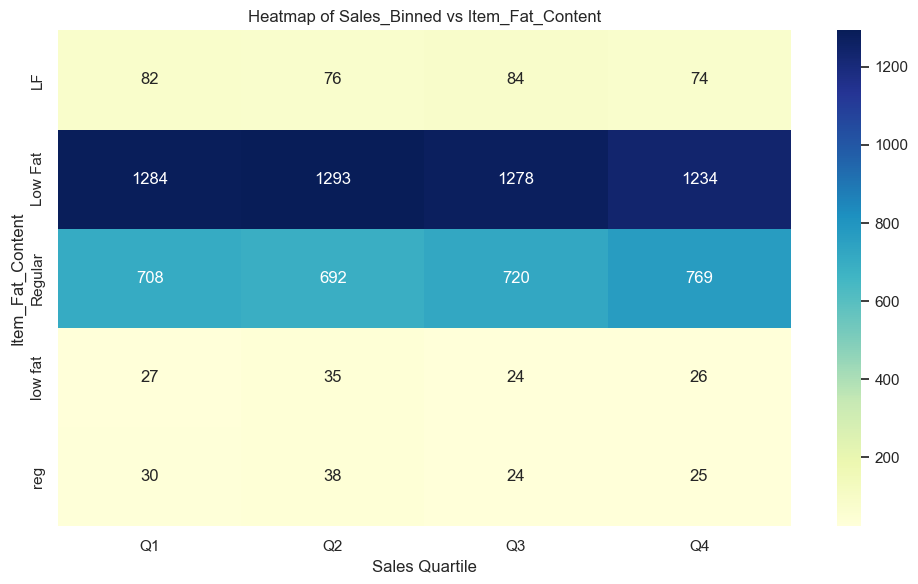

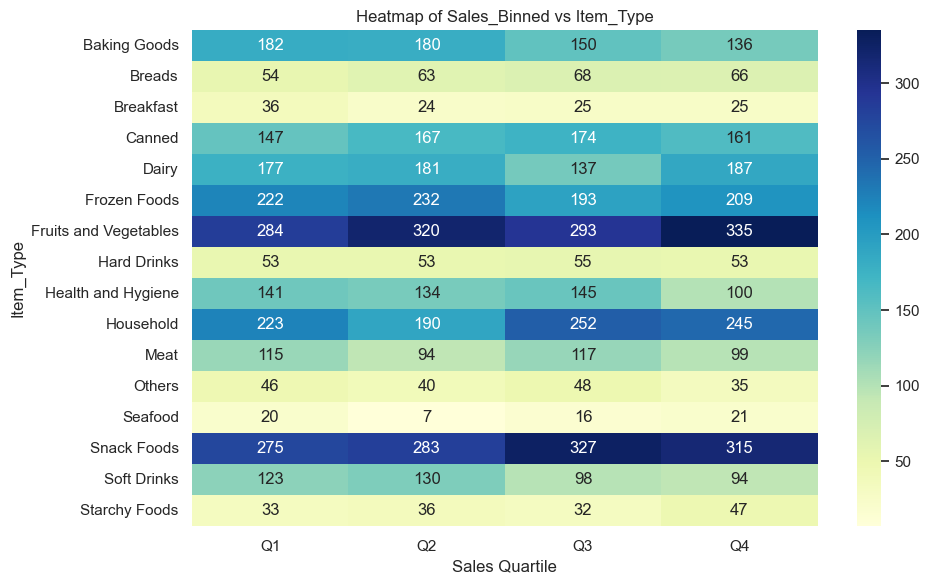

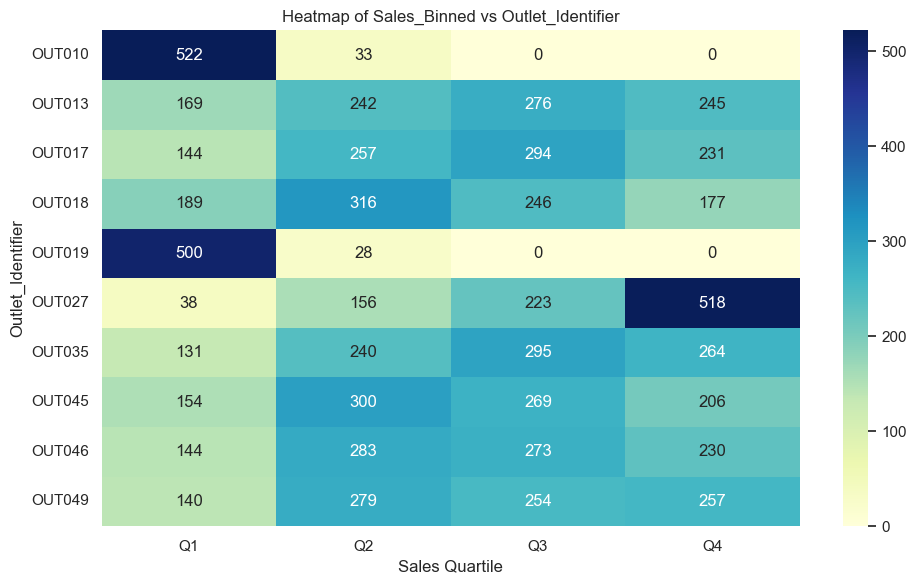

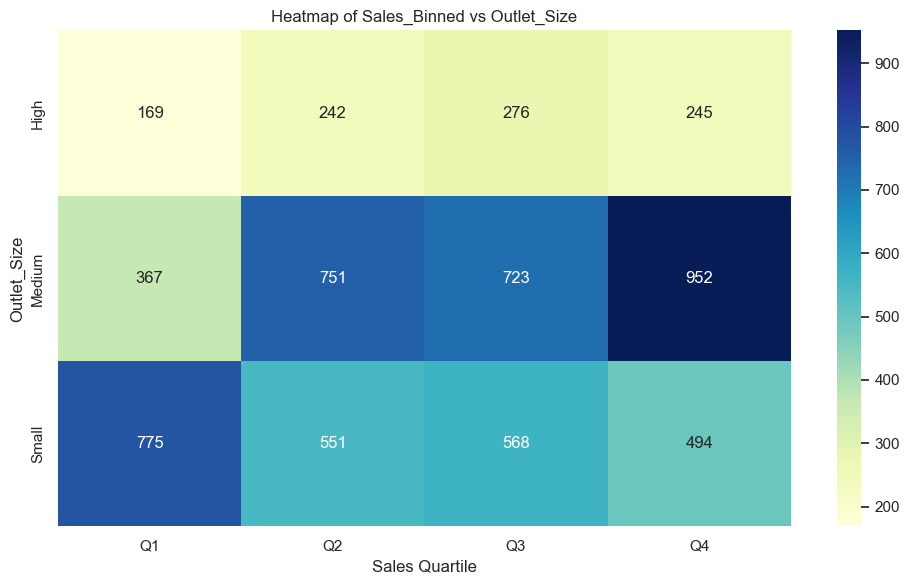

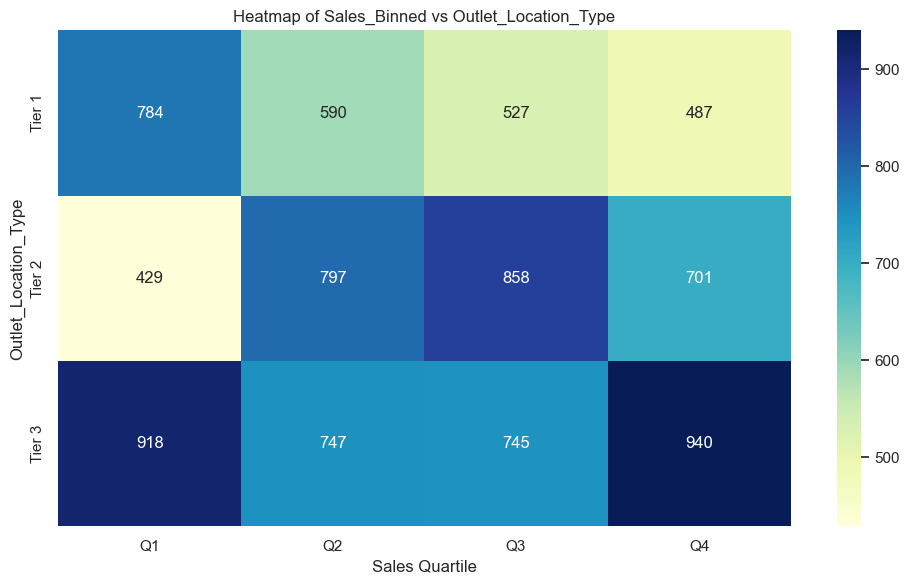

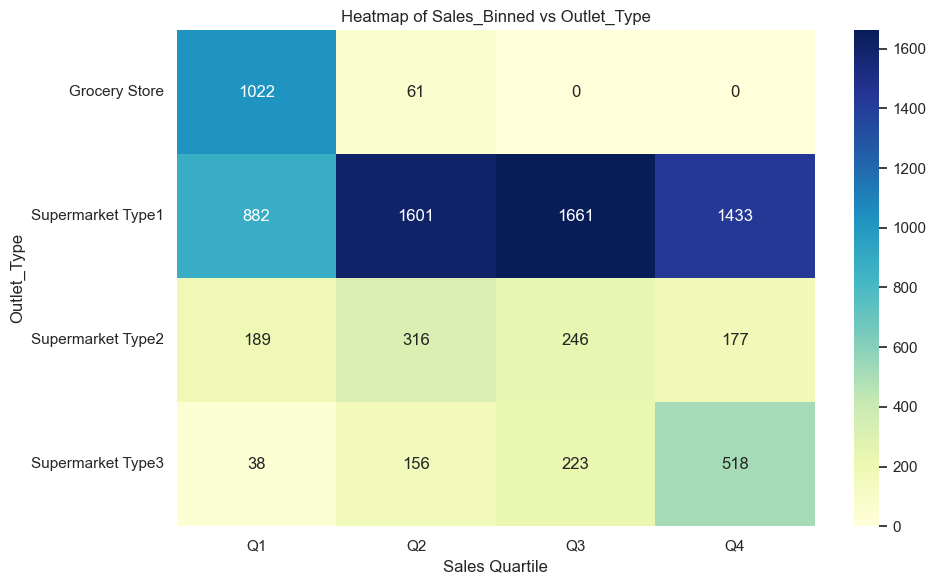

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 매출액을 다시 범주형으로 변환 (drop 후 재사용을 위함)
bigmt['Sales_Binned'] = pd.qcut(bigmt['Item_Outlet_Sales'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# 시각화: 각 범주형 변수에 대해 교차표를 히트맵으로 표현
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    
    # 교차 테이블 생성
    crosstab = pd.crosstab(bigmt[col], bigmt['Sales_Binned'])
    
    # 히트맵 그리기
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"Heatmap of Sales_Binned vs {col}")
    plt.ylabel(col)
    plt.xlabel("Sales Quartile")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 다시 제거
bigmt.drop(columns=['Sales_Binned'], inplace=True)


In [148]:
bigmt.drop(columns=['Item_Fat_Content'], inplace=True)
bigmt.head()

,Item_Identifier,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## 이상치 처리하기

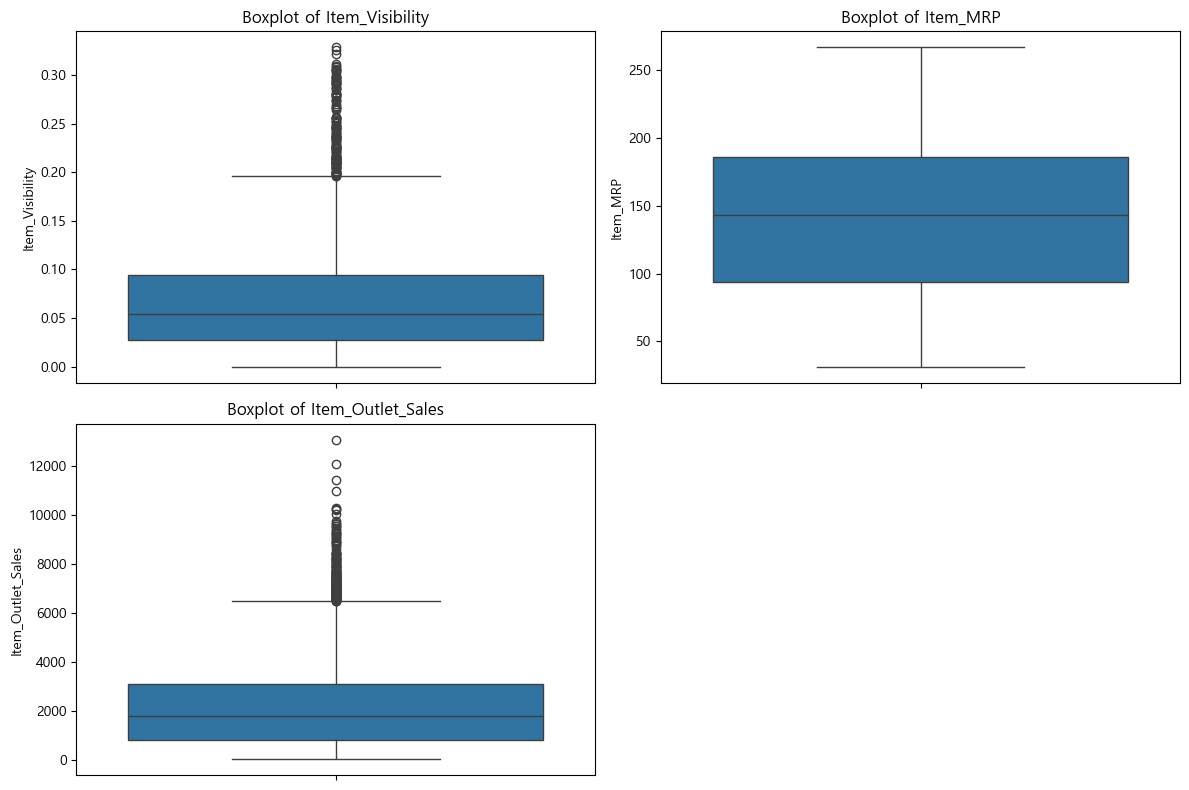

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 로드 
numeric_columns = ["Item_Visibility", "Item_MRP", "Item_Outlet_Sales"]

# 박스플롯 그리기
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=bigmt[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

#### 상품 노출도 이상치 전처리

In [31]:
# Item_Visibility가 0인 데이터 중에서 Item_Outlet_Sales가 0이 아닌 개수 확인
zero_visibility = bigmt[(bigmt["Item_Visibility"] == 0.0) & (bigmt["Item_Outlet_Sales"] > 0)].shape[0]

print(f"Item_Visibility가 0인데 매출액이 있는 데이터 개수: {zero_visibility}")

Item_Visibility가 0인데 매출액이 있는 데이터 개수: 526


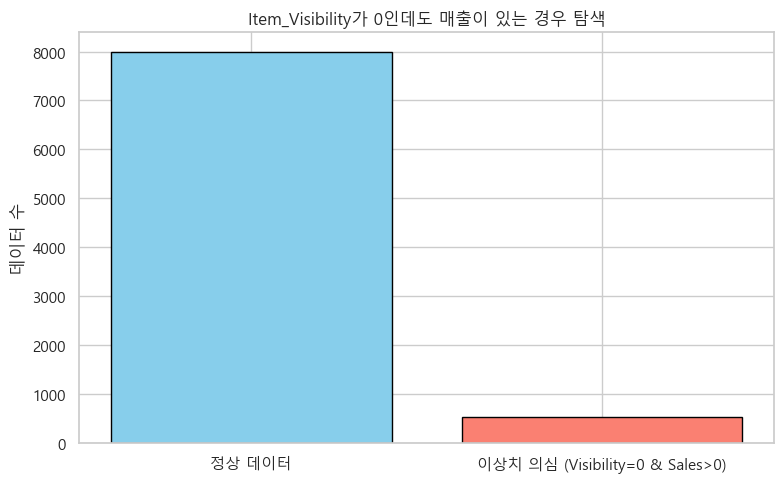

In [115]:
import matplotlib.pyplot as plt

# 이상값 조건: Visibility가 0인데 매출이 있는 경우
outlier_case = bigmt[(bigmt["Item_Visibility"] == 0.0) & (bigmt["Item_Outlet_Sales"] > 0)].shape[0]

# 정상값 조건: 그 외 모든 경우
normal_case = bigmt.shape[0] - outlier_case

# 시각화를 위한 데이터
counts = [normal_case, outlier_case]
labels = ['정상 데이터', '이상치 의심 (Visibility=0 & Sales>0)']
colors = ['skyblue', 'salmon']

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=colors, edgecolor='black')
plt.title('Item_Visibility가 0인데도 매출이 있는 경우 탐색')
plt.ylabel('데이터 수')
plt.tight_layout()
plt.show()


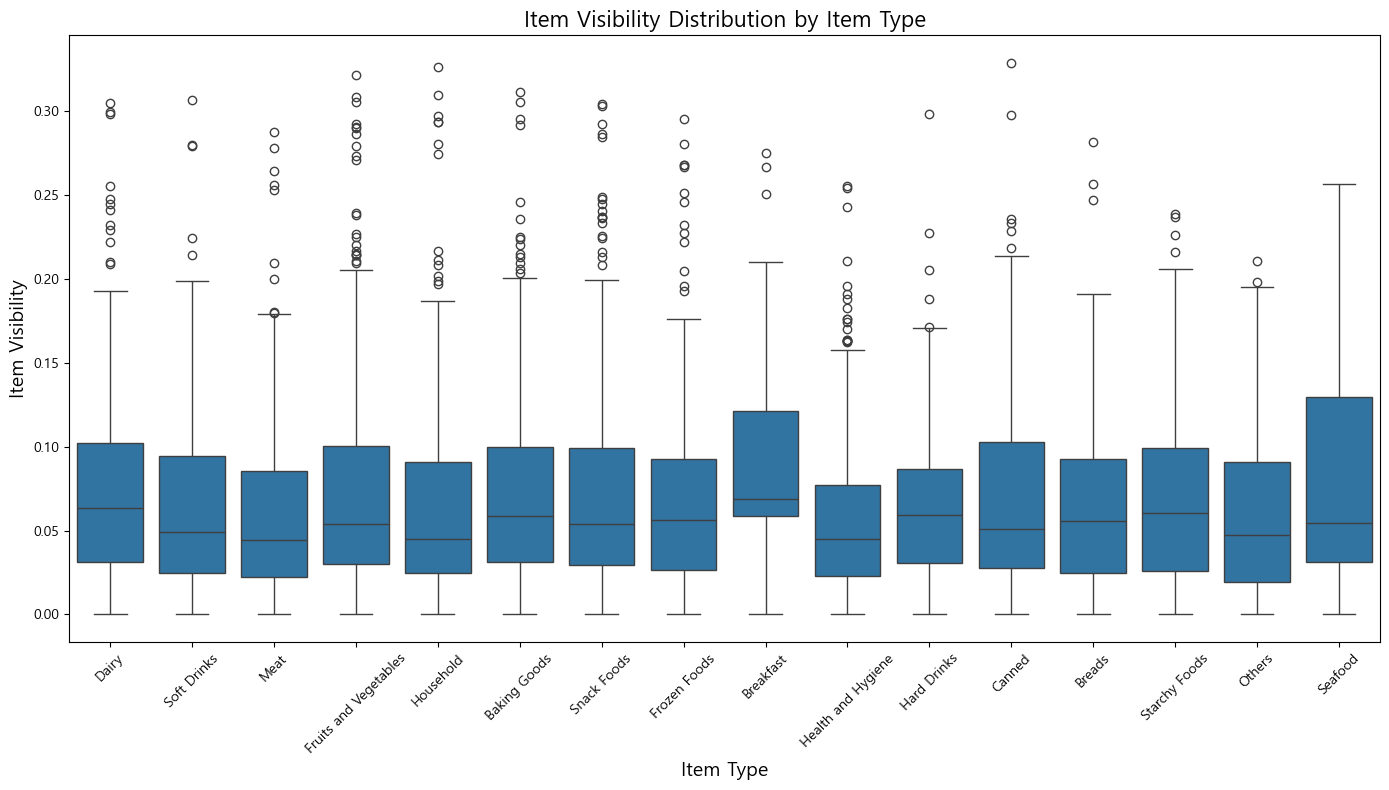

In [20]:
# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 상품 유형(Item_Type)별로 상품 노출도(Item_Visibility)의 박스플롯 그리기
sns.boxplot(x='Item_Type', y='Item_Visibility', data=bigmt)

# 그래프 제목 및 라벨 설정
plt.title('Item Visibility Distribution by Item Type', fontsize=16)
plt.xlabel('Item Type', fontsize=14)
plt.ylabel('Item Visibility', fontsize=14)

# 그래프 표시
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()
plt.show()

In [149]:
old_visibility = bigmt['Item_Visibility'].copy()

# 평균을 사용할 Item_Type 리스트
mean_types = ['Breakfast', 'Snack Foods', 'Others', 'Seafood']

# 1. 같은 상품 + 같은 매장 + 상품 유형 조건에 따라 평균 or 중앙값으로 대체
def replace_visibility_rowwise(row, group_df):
    if row['Item_Visibility'] != 0:
        return row['Item_Visibility']
    group = group_df.get_group((row['Item_Identifier'], row['Outlet_Identifier'], row['Item_Type']))
    if row['Item_Type'] in mean_types:
        return group['Item_Visibility'].mean()
    else:
        return group['Item_Visibility'].median()

# 그룹화된 데이터 만들기
grouped1 = bigmt.groupby(['Item_Identifier', 'Outlet_Identifier', 'Item_Type'])
# 0 값만 처리
bigmt['Item_Visibility'] = bigmt.apply(lambda row: replace_visibility_rowwise(row, grouped1), axis=1)


# 2. 같은 상품 유형 기준으로 평균 or 중앙값으로 대체
def replace_visibility_itemtype(row, group_df):
    if row['Item_Visibility'] != 0:
        return row['Item_Visibility']
    group = group_df.get_group(row['Item_Type'])
    if row['Item_Type'] in mean_types:
        return group['Item_Visibility'].mean()
    else:
        return group['Item_Visibility'].median()

# 그룹화된 데이터 만들기
grouped2 = bigmt.groupby('Item_Type')
# 0 값만 처리
bigmt['Item_Visibility'] = bigmt.apply(lambda row: replace_visibility_itemtype(row, grouped2), axis=1)


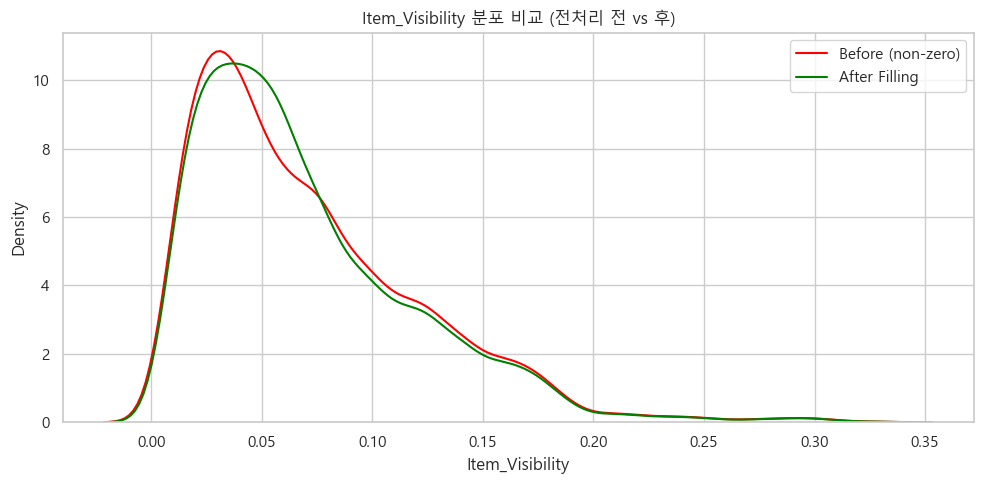

In [117]:
plt.figure(figsize=(10, 5))
sns.kdeplot(old_visibility[old_visibility > 0], label='Before (non-zero)', color='red')  # 0 제외한 분포
sns.kdeplot(bigmt['Item_Visibility'], label='After Filling', color='green')

plt.title('Item_Visibility 분포 비교 (전처리 전 vs 후)')
plt.xlabel('Item_Visibility')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# 확인하기
zero_Visibility = (bigmt['Item_Visibility'] == 0).sum()
print(f"Item_Visibility가 0인 데이터 개수: {zero_Visibility}")

Item_Visibility가 0인 데이터 개수: 0


### Feature 생성

#### Item_Type을 상품군으로 그룹핑 하기

In [128]:
item_type_mapping = {
    # 가공식품
    'Dairy': 'Processed_Food', #유제퓸
    'Baking Goods': 'Processed_Food', #베이킹 재료
    'Snack Foods': 'Processed_Food', # 스낵류
    'Breakfast': 'Processed_Food', # 아침식사류
    'Frozen Foods': 'Processed_Food', #냉동식품
    'Canned': 'Processed_Food', # 통조림
    'Starchy Foods': 'Processed_Food', #전분식품
    'Breads': 'Processed_Food', # 빵류

    # 신선식품
    'Meat': 'Fresh_Food', # 고기
    'Fruits and Vegetables': 'Fresh_Food',  # 과일 및 채소
    'Seafood': 'Fresh_Food', # 해산물

    # 음료
    'Soft Drinks': 'Soft_Beverage',     # 청량음료
    'Hard Drinks': 'Alcoholic_Beverage',# 주류

    # 생활용품
    'Household': 'Daily necessities',     # 가정용품
    'Health and Hygiene': 'Daily necessities',    # 위생용품

    # 기타
    'Others': 'Others'
}

In [129]:
bigmt['Item_Type'] = bigmt['Item_Type'].map(item_type_mapping)

#### 매장별 품목 평균 노출도

In [150]:
# 매장별 + 품목별 평균 노출도 계산
bigmt['Avg_Visibility'] = bigmt.groupby(['Outlet_Identifier', 'Item_Type'])['Item_Visibility'].transform('mean')

# 파생 변수: 매장 + 품목 기준 대비 상대 노출도
bigmt['Outlet_ItemType_Visibility'] = bigmt['Item_Visibility'] / bigmt['Avg_Visibility']

### 운영 연수 파생변수 만들기

In [151]:
# 운영 연수 파생변수 만들기
bigmt['Outlet_Age'] = 2025 - bigmt['Outlet_Establishment_Year']

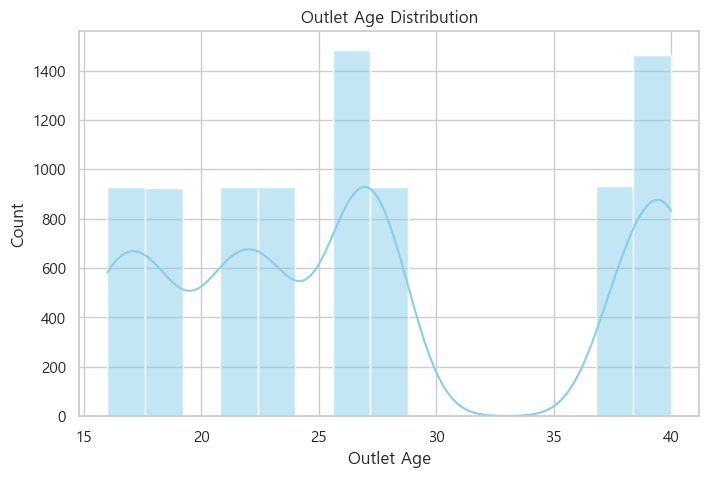

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(data=bigmt, x='Outlet_Age', bins=15, kde=True, color='skyblue')
plt.title('Outlet Age Distribution')
plt.xlabel('Outlet Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()


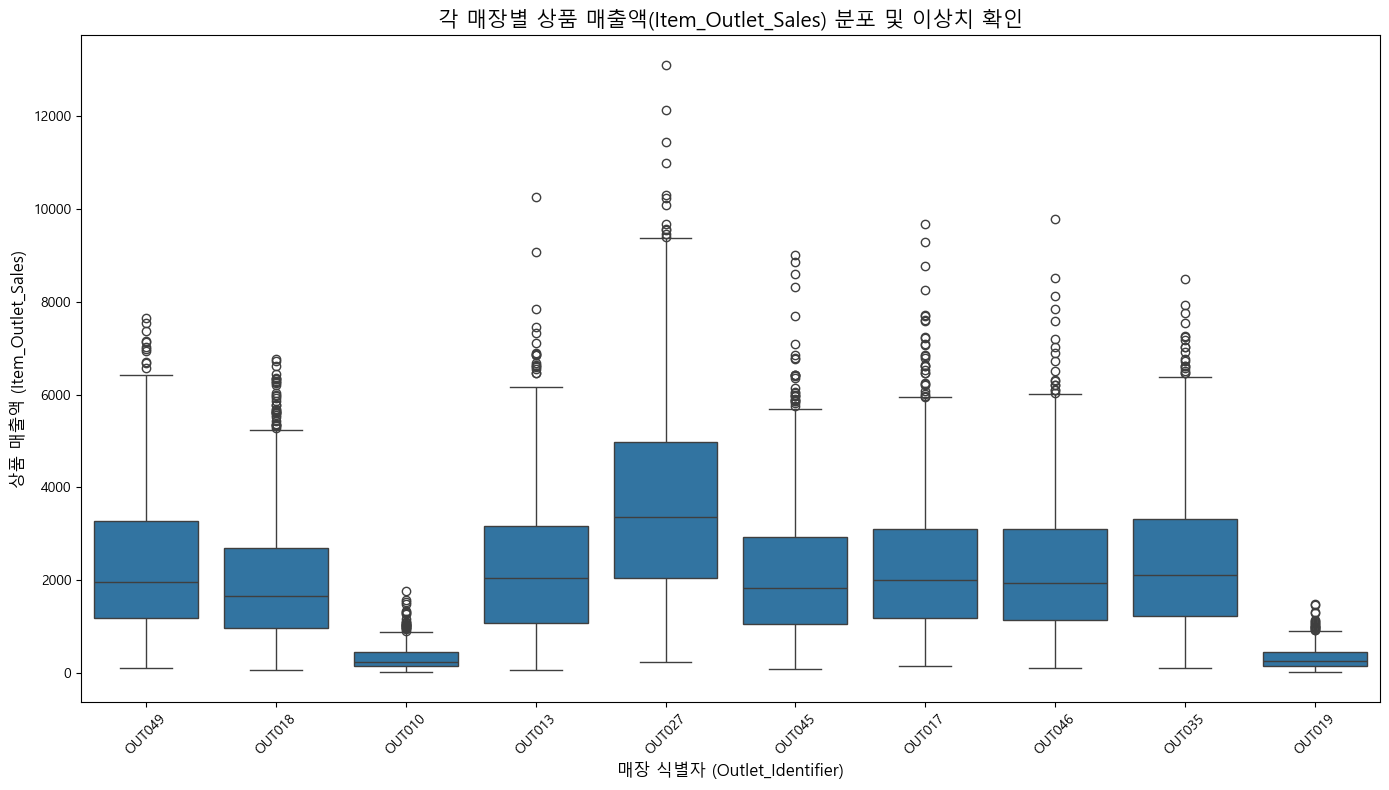

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 박스플롯 그리기
sns.boxplot(data=bigmt, x="Outlet_Identifier", y="Item_Outlet_Sales")

# 그래프 제목 및 레이블 설정
plt.title("각 매장별 상품 매출액(Item_Outlet_Sales) 분포 및 이상치 확인", fontsize=15)
plt.xlabel("매장 식별자 (Outlet_Identifier)", fontsize=12)
plt.ylabel("상품 매출액 (Item_Outlet_Sales)", fontsize=12)
plt.xticks(rotation=45)

# 그래프 출력
plt.tight_layout()
plt.show()


## 범주형 컬럼 인코딩 하기

In [153]:
df = bigmt.copy()

df.drop(columns=['Item_Identifier','Item_Type','Outlet_Identifier','Avg_Visibility','Outlet_Establishment_Year','Item_Visibility'], inplace=True)
df.head()

,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_ItemType_Visibility,Outlet_Age
0,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380,0.238480,26
1,48.2692,Medium,Tier 3,Supermarket Type2,443.4228,0.306530,16
2,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700,0.260544,26
3,182.0950,Small,Tier 3,Grocery Store,732.3800,0.500743,27
4,53.8614,High,Tier 3,Supermarket Type1,994.7052,0.786158,38


In [154]:
from sklearn.preprocessing import LabelEncoder

# Ordinal Encoding
size_map = {'Small':0, 'Medium': 2, 'High': 1}
location_map = {'Tier 1' :2, 'Tier 2':1, 'Tier 3':0}
type_map = {'Grocery Store': 0, 'Supermarket Type1':2,'Supermarket Type2':1,'Supermarket Type3':3}

df['Outlet_Size'] = df['Outlet_Size'].map(size_map)
df['Outlet_Location_Type'] = df['Outlet_Location_Type'].map(location_map)
df['Outlet_Type'] = df['Outlet_Type'].map(type_map)

# df = pd.get_dummies(df, columns=['Outlet_Identifier'], drop_first = True)

## 데이터 스케일링

### StandardScaler (평균 0, 표준편차 1)

In [155]:
from sklearn.preprocessing import StandardScaler

# 1. y (종속 변수) 따로 분리
y = df['Item_Outlet_Sales']

# 2. X (입력 특성)만 스케일링
X = df.drop('Item_Outlet_Sales', axis=1)

# 3. 스케일러 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. 다시 DataFrame으로 변환 + y값 붙이기
scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
scaled_df['Item_Outlet_Sales'] = y.values  # y를 마지막 컬럼으로 붙임

## 회귀 인공신경망 모델 학습

In [156]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from tensorflow.keras.callbacks import EarlyStopping

# 입력, 출력 설정
X = scaled_df.drop('Item_Outlet_Sales', axis=1)
y = scaled_df['Item_Outlet_Sales']

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 옵티마이저 목록과 설정
optimizers = {
    'SGD': SGD(learning_rate=1e-7),
    'Momentum': SGD(learning_rate=1e-7, momentum=0.9, nesterov=True),
    'AdaGrad': Adagrad(learning_rate=0.189, epsilon=1e-7),
    'RMSProp': RMSprop(learning_rate=0.001, rho=0.87, epsilon=1e-7),
    'Adam': Adam(learning_rate=0.001, beta_1=0.90, beta_2=0.87, epsilon=1e-7)
}

# 평가를 위한 코드 (최종 손실, R2, val_loss 포함)
results = []

for name, optimizer in optimizers.items():
    # 모델 구성
    model = Sequential()
    model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    # 옵티마이저 설정 및 컴파일
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

    # 얼리 스탑 설정
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 학습 (validation_split을 통해 검증 손실을 추적)
    history = model.fit(X_train, y_train,
                        epochs=150,
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=[early_stop],
                        verbose=0)  # 학습 로그 생략

    # 평가 (y_pred 예측, R2 score 계산)
    y_pred = model.predict(X_test).flatten()
    r2 = r2_score(y_test, y_pred)

    # 마지막 훈련 손실과 검증 손실 (val_loss)
    final_loss = history.history['loss'][-1]  # 마지막 훈련 손실
    val_loss = history.history['val_loss'][-1]  # 마지막 검증 손실

    # 결과 저장
    results.append({
        'Optimizer': name,
        'Loss': round(final_loss, 2),
        'val_Loss': round(val_loss, 2),
        'R² Score': round(r2, 4)
    })

# 결과 출력 (R2 Score에 따라 정렬)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='R² Score', ascending=False))

C:\Users\82109\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\82109\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\82109\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\82109\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\82109\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Optimizer        Loss    val_Loss  R² Score
4      Adam  1183012.50  1248824.88    0.6180
1  Momentum  1188195.88  1251962.38    0.6178
2   AdaGrad  1183216.50  1255680.25    0.6171
3   RMSProp  1191225.75  1253114.00    0.6157
0       SGD  1196855.25  1251441.12    0.6138


C:\Users\82109\AppData\Local\Temp\ipykernel_15300\2922262516.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_results, x='Optimizer', y='R² Score', palette='viridis')


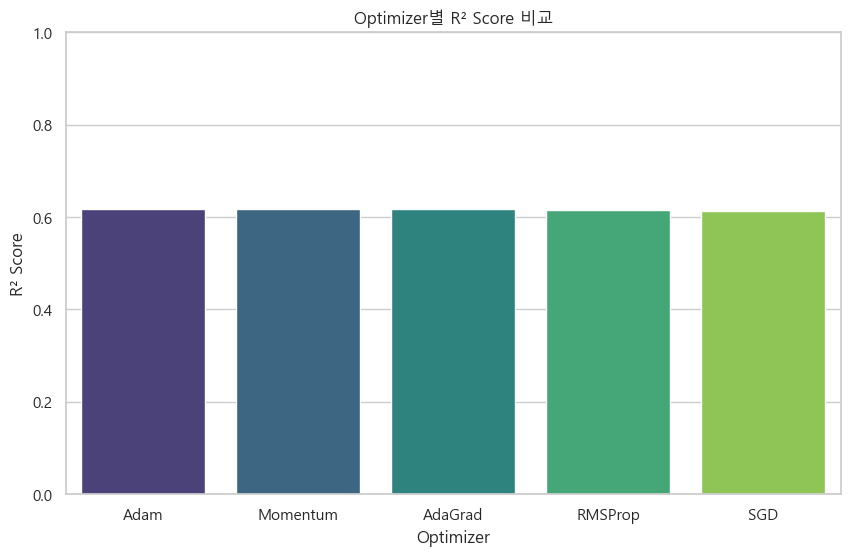

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

# 정렬된 결과
sorted_results = results_df.sort_values(by='R² Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=sorted_results, x='Optimizer', y='R² Score', palette='viridis')
plt.title('Optimizer별 R² Score 비교')
plt.ylim(0, 1)  # 회귀 성능이므로 0~1 범위
plt.ylabel('R² Score')
plt.xlabel('Optimizer')
plt.grid(True, axis='y')
plt.show()


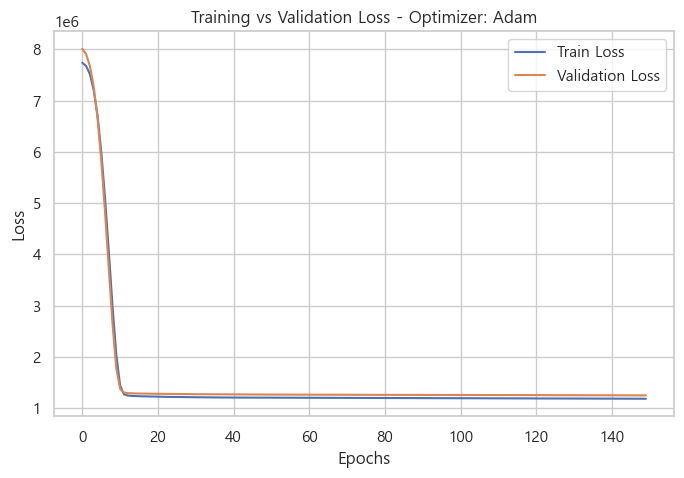

In [158]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Training vs Validation Loss - Optimizer: {name}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


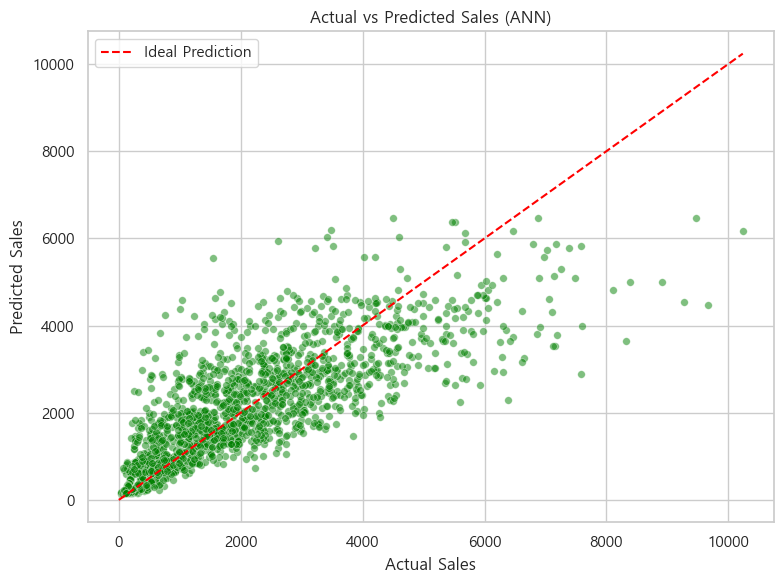

In [159]:
# 산점도 그래프
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, s=30, color='green')

# 대각선 (완벽 예측선)
max_val = max(max(y_test), max(y_pred))
plt.plot([0, max_val], [0, max_val], '--', color='red', label='Ideal Prediction')

# 그래프 설정
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales (ANN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
